In [1]:
import os
#import pytorch_lightning as pl
import numpy as np
import torch as ch
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset
import scipy.stats as stats
from argparse import ArgumentParser
from uuid import uuid4
import torch as ch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from os import path

In [2]:
def plot_genes(labels_data0, yhat_data0, cmap, index):
  
    all_d = pd.concat([pd.DataFrame(labels_data0), pd.DataFrame(yhat_data0[:,index])], axis = 1)
    all_d.columns = ['x', 'y','z','feature'+str(index)]

    
    g = sns.scatterplot(data = all_d, x = 'x', y = 'y', hue = 'feature'+str(index),palette= cmap)
    
    return g

def load_data(data_dir, prefix="Cell"):
        #expr = pd.read_csv(os.path.join(data_dir, "data_table.csv"), index_col=0)
    expr = pd.read_csv(os.path.join(data_dir, "cell_barcode_count.csv"), header=None)
    gene_names = pd.read_csv(os.path.join(data_dir, "cell_barcode_names.csv"),header=None)
    rownames = [i for i in range(expr.shape[0])]
    names = gene_names[2]
    names.name = "Gene"
    return pd.DataFrame(data=expr.values, columns=names, index=rownames)



In [3]:
import sys
sys.path.append('/Users/bbbgu/')

from mlgenomics.djuna_models.MatrixFNN_Djuna import SimpleFNN

In [4]:
# load the model (change the directory to point to your location of mlgenomics)
PATH = '/Users/bbbgu/mlgenomics/djuna_models/lightning_logs/version_0_Wang_2018_all_2D_3D_processed_new/checkpoints/epoch=517-v0.ckpt'
new_model_unseen = SimpleFNN.load_from_checkpoint(checkpoint_path=PATH)
new_model_unseen.eval()

"lr": 0.001


SimpleFNN(
  (layers): Sequential(
    (0): Linear(in_features=1030, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [18]:
# select dataset of interest
dataset_num=2
direct_leftout = '/Users/bbbgu/mlgenomics/data_preprocessing/Wang_2018_all_2D_3D_processed_new.npz'
content_leftout = np.load(direct_leftout)['arr_0']
unseen_0 = content_leftout[content_leftout[:,-1]==dataset_num,] # selecting features corresponding to dataset 

# col 0 to 1029 correspond to features
# col 1030-32 correspond to x,y,z (for 2D data, z = 0)
# col 1033 corresponds to the dataset annotation 
# where the order 0-9 corresponds to the datasets listed in the order below (ie 20180505_BY3_1kgenes = dataset1)
# the 3D dataset is dataset 10
#dirs = os.listdir('/Users/bbbgu/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

# get elements of the dataset and store as tensor

data_unseen = ch.from_numpy(unseen_0[:, :-4]).float()
# @Fatima: you can use the code in the previous code chunk to load the data you want to analyze, @Na: you would
# need to replace 'unseen_0' with the single-cell counts

coordinates_unseen = ch.from_numpy(unseen_0[:, -4:-1]).float()
dataindex_unseen = ch.from_numpy(unseen_0[:,-1]).float() 
full_dataset_unseen  = TensorDataset(data_unseen , coordinates_unseen , dataindex_unseen)


In [20]:
# run the model on the dataset 

# (you cann modify the for loop to include only the outputs you need (i.e. teh model predictions, out))

out = []
index = []
label = []
feature = []
for features, labels, dataset_idx in (iter(DataLoader(full_dataset_unseen))):
    label.append(labels.detach().numpy())
    index.append(dataset_idx.detach().numpy())
    feature.append(features.detach().numpy())
    out.append((new_model_unseen(features, dataset_idx)).detach().numpy())


In [21]:
# concatenate the output 

yhat = np.concatenate(out) # yhat corresponds to the model prediction (this is what you'll be interested in)
idx = np.concatenate(index)
label = np.concatenate(label) # corresponds to the actual coordinates
features = np.concatenate(feature) # corresponds to the input features

In [22]:
dirs=['20180505_BY3_1kgenes',
 '20171110_BF2_dark',
 '20180410-BY3_1kgenes',
 '20180421_BZ19_cocaine',
 '20170915_BD2_dark',
 '20171115_BF5_light',
 '20180424_BZ14_control',
 '20171120_BF4_light',
 '20180419_BZ9_control',
 '20180417_BZ5_control']


In [23]:
# get labels for this dataset

#dirs = os.listdir('/Users/bbbgu/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')
data_dir = os.path.join('/Users/bbbgu/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[dataset_num],'class_labels.csv')
celltype_labels = pd.read_csv(data_dir)

# subset the coordinates in labels to only include cells for which we have annotations
labels_subsetted = label[np.array(celltype_labels[['CellID']]).flatten(),:]
# N.B. for some datasets, we seem to have fewer celltype labels than cells. From what I can tell, he cellype
# labels correspond to the rows in the feature/label matrix (i.e cells for which we do not have labels are at the end)
# I am not 100% sure of this, but the annotations look right when I plot them 
# I think this is the case because in the load_data function provided by the authors, they annotate the rows
# with cell_ID + rownumber and thus the row indices correspond to the cellIDs, which correspond to the cellIDs in 
# the labels dataframe 

celltype_labels = np.array(celltype_labels[['ClusterName']]).flatten()

In [13]:
direct_leftout = '/Users/bbbgu/mlgenomics/data_preprocessing/Wang_2018_all_2D_3D_processed_new.npz'
content_leftout = np.load(direct_leftout)['arr_0']
#dirs = os.listdir('/Users/bbbgu/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')
for i in range(10):
    dataset_num=i
    unseen_0 = content_leftout[content_leftout[:,-1]==i,] # selecting features corresponding to dataset 
    print('unseen shape',unseen_0.shape)
    data_dir = os.path.join('/Users/bbbgu/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[dataset_num],'class_labels.csv')
    celltype_labels = pd.read_csv(data_dir)
    print('celltype shape',celltype_labels.shape)

unseen shape (1549, 1034)
celltype shape (1389, 3)
unseen shape (1167, 1034)
celltype shape (781, 3)
unseen shape (973, 1034)
celltype shape (973, 3)
unseen shape (1320, 1034)
celltype shape (1320, 3)
unseen shape (941, 1034)
celltype shape (941, 3)
unseen shape (975, 1034)
celltype shape (975, 3)
unseen shape (1215, 1034)
celltype shape (1215, 3)
unseen shape (931, 1034)
celltype shape (931, 3)
unseen shape (1380, 1034)
celltype shape (1380, 3)
unseen shape (1127, 1034)
celltype shape (1127, 3)


In [25]:
###helper function to get cell of specific type
def get_cell(name):
    non_neuron=set(('Astro-1', 'Astro-2', 'Endo', 'Micro', 'Oligo', 'Smc', 'Astro'))
    found=False
    while not found:
        attempt=np.random.randint(0,len(celltype_labels)-1)
        if name=='all':
            return attempt
        elif celltype_labels[attempt]=='nan':
            found=False
        elif name=='neuron':
            if celltype_labels[attempt] not in non_neuron:
                return attempt
        elif name=='Astro':
            if celltype_labels[attempt] in ['Astro-1', 'Astro-2','Astro']:
                return attempt
        else:
            if name==celltype_labels[attempt]:
                return attempt
        

In [27]:
def test_pair(name1,name2):
    cell1=get_cell(name1)
    cell2=get_cell(name2)
    ###ensure we don't measure distance between the same cell, which is trivially always 0
    while cell1==cell2:
        cell2=get_cell(name2)
    pred_dist=np.linalg.norm(yhat[cell1]-yhat[cell2])
    act_dist=np.linalg.norm(label[cell1]-label[cell2])
    #error=(act_dist-pred_dist)/act_dist
    error=act_dist-pred_dist
    return error

neuron_neuron=[]
neuron_astro=[]
astro_astro=[]
el23_el23=[]
#el6_el6=[]
endo_endo=[]

for n in range(1000):
    neuron_neuron.append(test_pair('neuron','neuron'))
    neuron_astro.append(test_pair('neuron','Astro'))
    astro_astro.append(test_pair('Astro','Astro'))
    el23_el23.append(test_pair('eL2/3','eL2/3'))
    #el6_el6.append(test_pair('eL6','eL6'))
    endo_endo.append(test_pair('Endo','Endo'))

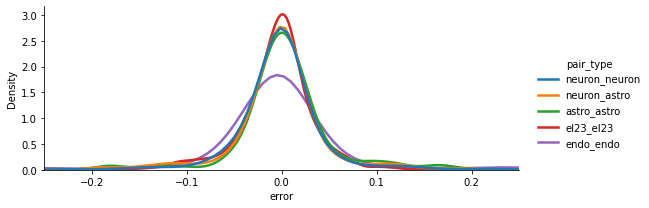

In [26]:
dat1=pd.DataFrame({'error':neuron_neuron})
dat1['pair_type']="neuron_neuron"
dat2=pd.DataFrame({'error':neuron_astro})
dat2['pair_type']="neuron_astro"
dat3=pd.DataFrame({'error':astro_astro})
dat3['pair_type']="astro_astro"
dat4=pd.DataFrame({'error':el23_el23})
dat4['pair_type']="el23_el23"
#dat5=pd.DataFrame({'error':el6_el6})
#dat5['pair_type']="el6_el6"
dat6=pd.DataFrame({'error':endo_endo})
dat6['pair_type']="endo_endo"

a=pd.concat([dat1,dat2,dat3,dat4,dat6])
#a=pd.concat([dat1,dat2,dat3,dat4,dat5,dat6])

sns.displot(a,x='error',hue='pair_type',kind="kde",height=3,aspect=2.5,linewidth=2.5)
plt.xlim(-.25,.25)
plt.savefig("error_by_celltypes_absolute_extended.png")
#plt.savefig("error_by_celltypes_relative_extended.png",dpi=600)

In [29]:
# get gene annotations: all_genes correspond to the column labels from column 0 to column N (where N = len(all_genes))
# in Wang_2018_all_2D_3D_processed_new

genenames_3D = pd.read_csv('/Users/bbbgu/mlgenomics/data_as_downloaded/sequentially_encoded_Wang_et_al_2018/gene_names.csv', header = 0)

#dirs = os.listdir('/Users/bbbgu/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

ct = []
for i in range(len(dirs)):

    data_dir1 = os.path.join('/Users/bbbgu/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[i])
    ct.append(load_data(data_dir1, prefix=""))

genenames = []
for i in range(len(dirs)):
    genenames.append(ct[i].columns)
all_genes = np.unique(np.concatenate((np.unique(np.concatenate(genenames)),(np.array(genenames_3D).flatten()))))


In [30]:
def get_saliency(val,a):
    # preprocess input
    inp1=ch.from_numpy(np.expand_dims(features[val],0))
    inp1.requires_grad=True
    inp2=ch.tensor([idx[val]])
    inp2.requires_grad=False
    net=new_model_unseen
    # we would run the model in evaluation mode
    net.eval()
    scores = net(inp1,inp2)
    ###a is the final neuron number (0 1 or 2)
    scores[0,a].backward()
    sal=inp1.grad.data[0]
    return sal

In [31]:
def saliency_trial(name,a):
    saliencies=[]
    for i in range(100):
        val=get_cell(name)
        saliencies.append(np.array(get_saliency(val,a)))
    return saliencies

In [32]:
def sal_result(name,a):
    res=np.array(saliency_trial(name,a))
    average_sal=np.average(res,axis=0)
    result=pd.DataFrame({'saliency':average_sal})
    result['name']=all_genes
    result['abs_sal']=np.absolute(average_sal)
    return result.sort_values('abs_sal',ascending=False)

In [67]:
sal_result("Astro",0).head(20)

,saliency,name,abs_sal
520,8.875674,Mobp,8.875674
7,5.861845,3110035E14Rik,5.861845
120,-5.603605,Camk2n1,5.603605
506,-5.107655,Mef2c,5.107655
802,4.705859,Rspo2,4.705859
119,-4.541044,Camk2d,4.541044
259,-4.482107,Elavl2,4.482107
35,-4.273508,Adk,4.273508
23,4.143876,Acss1,4.143876
428,-4.036538,Itm2a,4.036538


<AxesSubplot:xlabel='x1', ylabel='y1'>

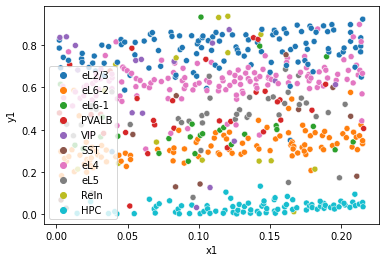

In [41]:
# plot cells to check 
include = set(('Astro-1',
 'Astro-2',
 'Endo',
 'Micro',
 'Oligo',
 'Astro', 'Smc', 'Astro'))

subsetted_labels_neurons = [None if item in include else item for item in celltype_labels]
data=pd.DataFrame(labels_subsetted)
data.columns=['x1','y1','hello']
sns.scatterplot(data = data, x = 'x1', y = 'y1', hue =subsetted_labels_neurons)


Text(0.5, 1.0, 'Mef2c')

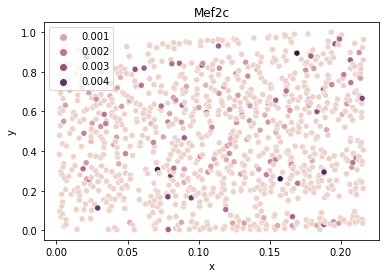

In [110]:
sns.scatterplot(data = data, x = 'x1', y = 'y1', hue =unseen_0[:,35])
plt.xlabel("x")
plt.ylabel("y")
#plt.title("Mef2c")
#plt.savefig("Mef2c.png")
                

In [47]:
def get_color(include,gene):

    color=[]
    for i in range(len(celltype_labels)):
        if celltype_labels[i] in include:
            color.append(unseen_0[i,gene])
        else:
            color.append(None)
    return color


Text(0, 0.5, 'y')

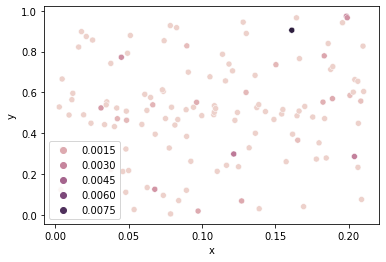

In [108]:
color=get_color(["Astro-1","Astro-2"],119)

sns.scatterplot(data = data, x = 'x1', y = 'y1', hue =color)
plt.xlabel("x")
plt.ylabel("y")
#plt.title("Etv1-astrocytes")

#plt.savefig("Etv1_astro.png")

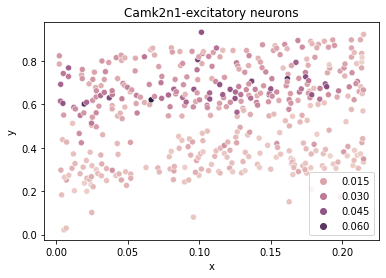

In [81]:
color=get_color(["eL6-1","eL6-2","eL2/3","eL4","eL5"],120)

sns.scatterplot(data = data, x = 'x1', y = 'y1', hue =color)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Camk2n1-excitatory neurons")

plt.savefig("Camk2n1_excitatory neurons.png")

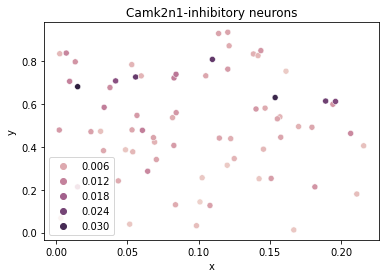

In [87]:
color=get_color(["SST","Reln","PVALB","VIP"],120)

sns.scatterplot(data = data, x = 'x1', y = 'y1', hue =color)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Camk2n1-inhibitory neurons")

plt.savefig("Camk2n1_inhibitory neurons.png")